<a href="https://colab.research.google.com/github/shradhautk/AI-MICROSCOPY-WORKSHOP/blob/main/Day2_Education_Day/VAE/DKL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep kernel learning for data reconstruction and automated experiment

*Prepared by Maxim Ziatdinov (January 2022)*

This notebook demonstrates how to use deep kernel learning (DKL) for data reconstruction and automated experiments. We will be using a pre-acquired STEM-EELS experimental dataset on plasmonic nanoparticles from Kevin Roccapriore.

The DKL can be viewed as an extension of Gaussian process (GP) for high-dimensional data. Hence, we first briefly overview the standard GP. GP is a powerful tool for reconstructing with quantified uncertainty an unknown  (“black-box”) function  over a low-dimensional parameter space. Formally, given a set of observed data points $(x_i, y_i)_{i=1, ..., N}$ and assuming normally distributed observation noise $𝜀$, the GP can be defined as

$$y_i= f(x_i) + 𝜀_i$$
$$f ∼ MVN(0; K(x_i, x_j))$$

where $MVN$ stands for Multivariate Normal Distribution, $K$ is a kernel function,  and $f(x)$ is a "black-box" function we try to reconstruct. The functional form of the kernel $K$ is chosen prior to the experiment, and its hyperparameters are inferred from the observations using either Markov chain Monte Carlo methods or stochastic variational inference. 

Once the GP model is trained, we can use it to make a probabilistic prediction on new inputs. Specifically, the predictive mean and covariance on the new data $X_*$ are given by

$$𝜇_*=K(X_*,X|𝜃)K(X,X|𝜃)^{-1}y$$
$$𝛴_*=K(X_*,X_*|𝜃)-K(X_*,X|𝜃)K(X,X|𝜃)^{-1}K(X,X_*|𝜃)$$

where 𝜃 are learned GP kernel parameters. Note that we absorbed model noise into the computation of kernel function. The predictive uncertainty is given by the square root of the diagonal elements of the covariance matrix $U_*=\sqrt{\text{diag}(𝛴_*)}$.

The GP predictive mean and uncertainty can then be used to derive an acquisition function for selecting the next point to measure. Depending on the form of acqusition function, this can be referred to as active learning (discovering the overall data distribution) or Bayesian optimization (identifying global maximum or minimum). Here, we will refer to both of them as "active learning."

A significant limitation of the standard GP (and GP-based active learning) is that it does not scale well with the dimensionality of the parameter space. Another limitation is that the standard GP
does not, strictly speaking, learn representations of data which precludes us from using information from different experimental modalities to assist in selecting the next measurement point.

To address these issues, we have adapted a [deep kernel learning](https://arxiv.org/abs/1511.02222) (DKL) approach. DKL can be understood as a hybrid of deep neural network (DNN) and GP. The DNN serves as a feature extractor that allows reducing the complex high-dimensional features to low-dimensional descriptors on which a standard GP kernel operates. The parameters of DNN and GP kernel are inferred jointly in an end-to-end fashion. Practically, the DKL training inputs are usually patches from an (easy-to-acquire) structural image over a large field of view, and training targets represent a physical property of interest derived from the (hard-to-acquire) spectra measured in those patches. The DKL output on the new inputs (image patches for which there are no measured spectra) is the expected property value and associated uncertainty, which can be used to derive the next measurement point in the automated experiments. 

Formally, we define a deep kernel as

$$k_{DKL}(x_i,x_j|w,𝜃)=k_{base}(g(x_i|w),g(x_j|w)|𝜃)$$

where $g$ is a neural network with weights $w$ and $k_{base}$ is a standard GP kernel. The parameters of neural network and GP base
kernel are learned simultaneously via Markov chain Monte Carlo sampling techniques or a stochastic variational inference. The trained DKL model is then used for obtaining predictive mean and uncertainty and deriving the acquisition function the same way as for the standard GP.

GPax package has the fully Bayesian DKL (weights of neural network and GP hyperparameters are inferred using Hamiltonian Monte Carlo) and the Variational Inference approximation of DKL, viDKL. The fully Bayesian DKL can provide an asymptotically exact solution but is too slow for most automated experiments. Hence, for the latter, we use the viDKL.

## Installation

In [1]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q --upgrade git+https://github.com/pycroscopy/atomai # we will use the atomai's utility function for preparing the input data

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 40.0 MB/s eta 0:00:00


## Imports

In [2]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

filterwarnings("ignore", module="haiku._src.data_structures")

## Prepared data

Download training data:

In [3]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [4]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [5]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra)



In [6]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

/usr/local/lib/python3.10/dist-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 93))

Normalize data:

In [7]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

### Scalarizer
Next, we select a scalarizer function that will convert a measured spectrum into a scalar physical descriptor. The scalarizer defines the measure of physical interest to the response and acts as a reward towards the specific behavior in the experiment. The scalarizer can be created in almost unlimited number of ways. For example, it can be based
on the gross characteristic of the spectrum, such as area under curve, integrated intensity within certain energy range, area or width of hysteresis loop, etc. It can incorporate the physical model and physics-based analysis, for example converting predicted spectrum to specific materials parameters. It can be based on hybrid criteria defined via combinations of functional fits, decision trees, etc. Finally, it can be crowd sourced – if the neural network has been trained by human labelled data, or other form of expert system can be used. Ultimately however, the scalarizer should define the measure of physical interest much like the human operator would do.

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of the most prominent plasmonic peak, but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First, let's do it for a single spectrum:

25 0.2826059331244979


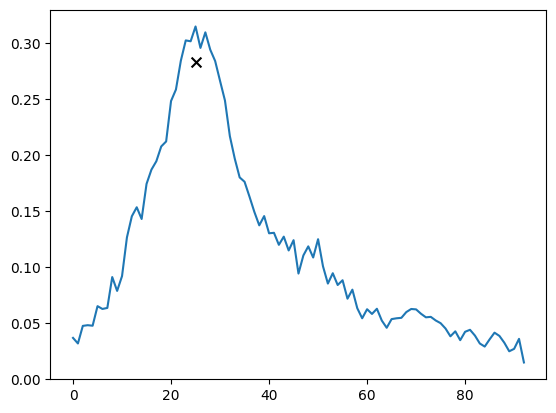

In [8]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Now for all the data:

In [9]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

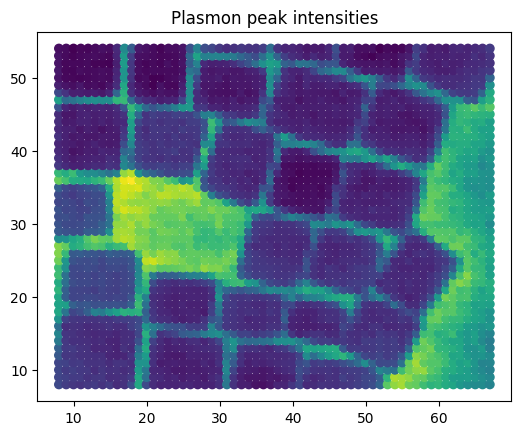

In [10]:
_, ax = plt.subplots()
ax.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)
ax.set_title('Plasmon peak intensities')
ax.set_aspect('equal')

## Reconstruction from partial data
Here we demonstrate how to use DKL to learn a correlative structure-property relationship from a relatively small number of image-(scalarized)spectrum pairs and then use the trained model to predict a targeted physical property for the entire image space.

Prepare data:

In [11]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Split the data in such a way that we use only a relatively small part of data (to the left of the vertical dashed line in the figure below) to train a DKL model and then use the trained model to make a prediction of the "unmeasured" plasmon peak values (the part to the right of the vertical dashed line):

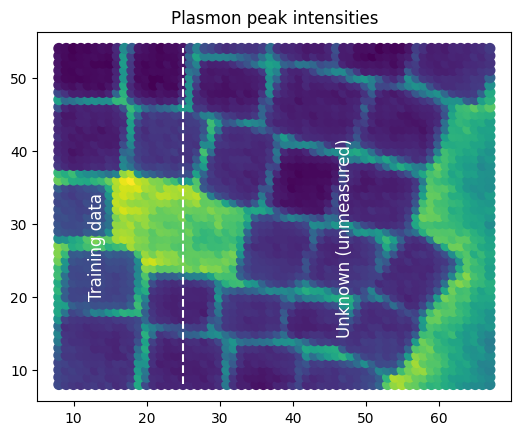

In [12]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

_, ax = plt.subplots(dpi=100)
ax.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax.text(split_ // 2, 20, 'Training data', c='w', size=12, rotation=90)
ax.text((split_ + indices[:, 1].max()) // 2, 15, 'Unknown (unmeasured)', c='w', size=12, rotation=90)
ax.set_title('Plasmon peak intensities');
ax.set_aspect('equal')

Initialize and train a DKL model:

In [13]:
data_dim = X_train.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:02<00:00, 45.42it/s, init loss: 21019.9002, avg. loss [96-100]: 18516.8690]



Inferred GP kernel parameters
k_length         [14.3821 21.8656]
k_scale          0.1559
noise            0.012400000000000001


Use the trained model to make a probabilsitic prediction for all the image patches:

In [14]:
mean, var = dkl.predict(key2, X)

Visualize predictive mean and uncertainty:

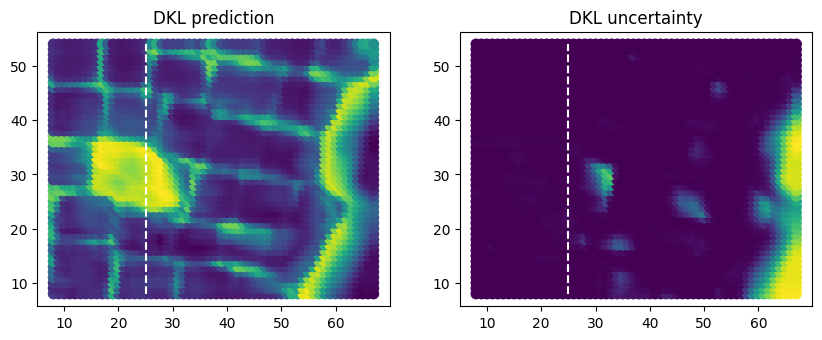

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), dpi=100)
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax1.set_title("DKL prediction")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax2.set_title("DKL uncertainty")
ax1.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
for _ax in fig.axes:
    _ax.set_aspect('equal')

We can also visualize the latent/embedding space:

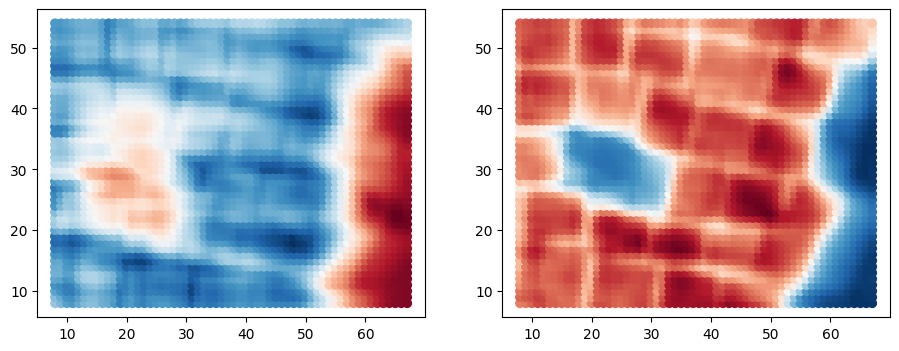

In [16]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## Active learning
Now we are going to use DKL to actively learn (local) structures where a particular physical behavior or property (here, plasmon resonance peak) is maximized. Starting with just a few "measured" point, we use DKL to obtain predictive mean and variance for our property of interest over the entire parameter space, and then use them to compute the upper confedence bound (UCB) acquisition function for sampling the next measurement point.

Prepare the data

In [17]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Get the initial measurements aka training points. Here ```X_measured``` are the already measured points, that is, the image patches for which there are measured spectra, whose scalarized values are stored in ```y_measured```. The ```X_unmeasured``` are unmeasured points, that is, image patches for which there are yet no measured spectra. 

In [18]:
# use only 0.02% of grid data points as initial training points
(X_measured, X_unmeasured, y_measured, y_unmeasured,
  indices_measured, indices_unmeasured) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=1)
  
seed_points = len(X_measured)

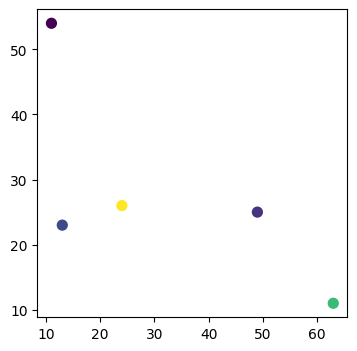

In [19]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_measured[:, 1], indices_measured[:, 0], s=50, c=y_measured)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/80


100%|██████████| 100/100 [00:01<00:00, 68.07it/s, init loss: 20124.5998, avg. loss [96-100]: 19061.5936]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2994
noise            0.1452


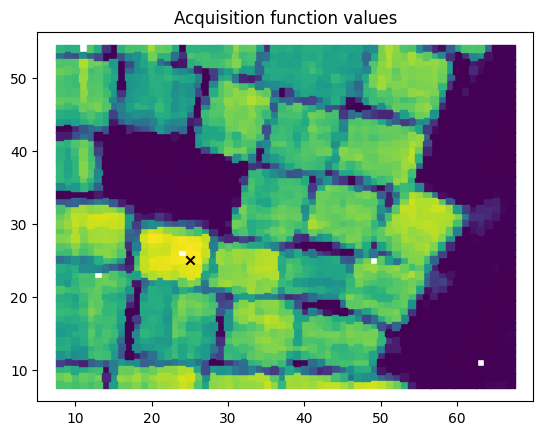

2/80


100%|██████████| 100/100 [00:01<00:00, 63.38it/s, init loss: 20126.0083, avg. loss [96-100]: 19062.0954]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3185
noise            0.1395


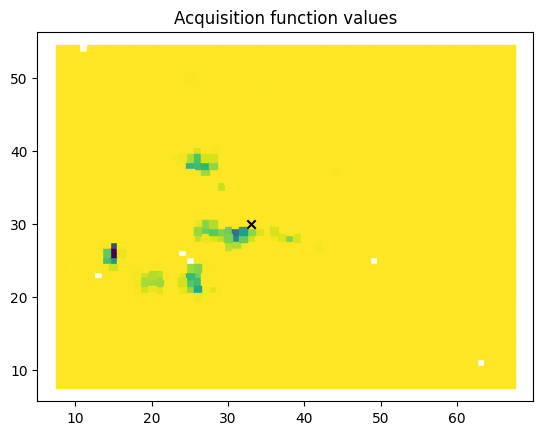

3/80


100%|██████████| 100/100 [00:01<00:00, 67.59it/s, init loss: 20127.3757, avg. loss [96-100]: 19062.2404]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3296
noise            0.1231


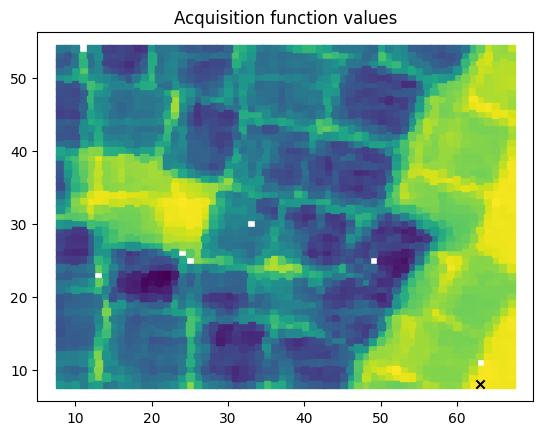

4/80


100%|██████████| 100/100 [00:01<00:00, 66.48it/s, init loss: 20128.6647, avg. loss [96-100]: 19062.1365]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33290000000000003
noise            0.10550000000000001


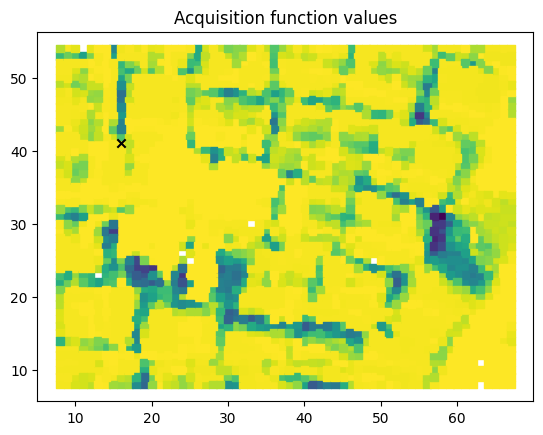

5/80


100%|██████████| 100/100 [00:01<00:00, 58.49it/s, init loss: 20129.9182, avg. loss [96-100]: 19062.3755]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32070000000000004
noise            0.1038


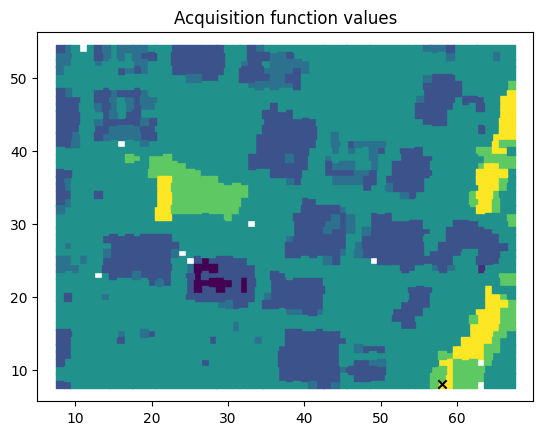

6/80


100%|██████████| 100/100 [00:01<00:00, 50.06it/s, init loss: 20131.2932, avg. loss [96-100]: 19062.4479]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3287
noise            0.0969


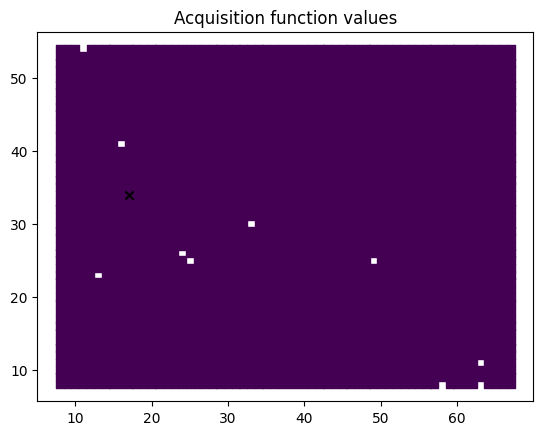

7/80


100%|██████████| 100/100 [00:01<00:00, 66.42it/s, init loss: 20132.7515, avg. loss [96-100]: 19063.0127]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3417
noise            0.1015


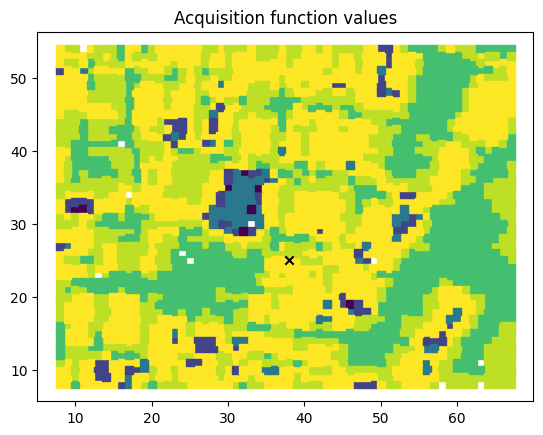

8/80


100%|██████████| 100/100 [00:01<00:00, 67.09it/s, init loss: 20134.0122, avg. loss [96-100]: 19063.1670]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.333
noise            0.0994


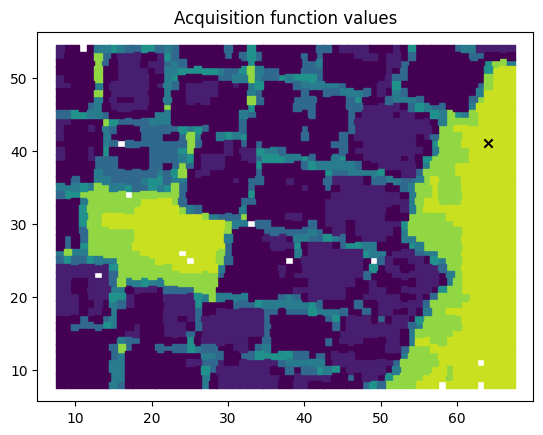

9/80


100%|██████████| 100/100 [00:01<00:00, 68.48it/s, init loss: 20135.3669, avg. loss [96-100]: 19063.0399]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33690000000000003
noise            0.0922


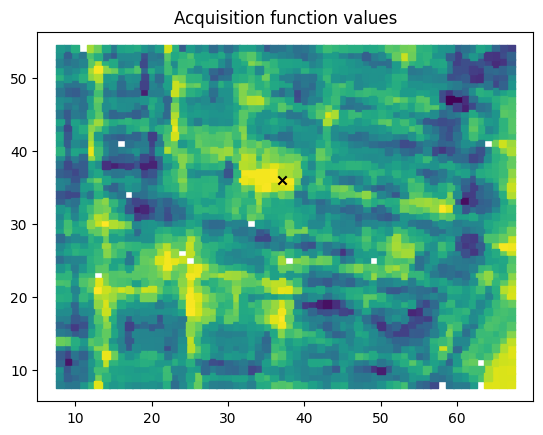

10/80


100%|██████████| 100/100 [00:01<00:00, 63.23it/s, init loss: 20136.6539, avg. loss [96-100]: 19062.8535]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3342
noise            0.0857


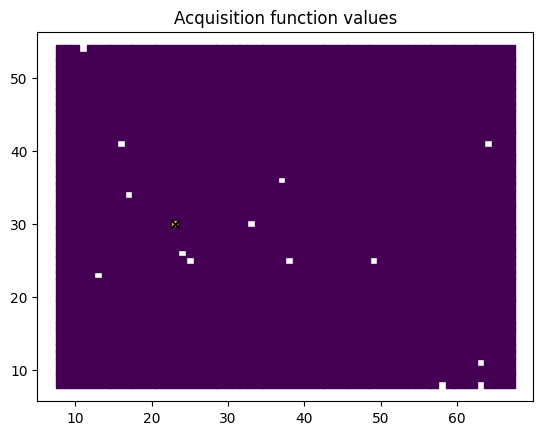

11/80


100%|██████████| 100/100 [00:01<00:00, 66.90it/s, init loss: 20137.9580, avg. loss [96-100]: 19062.8387]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3397
noise            0.0826


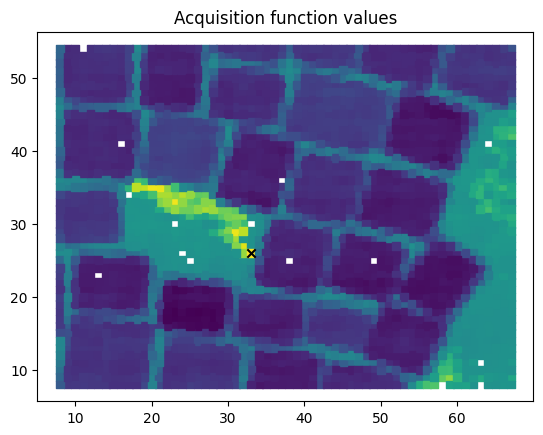

12/80


100%|██████████| 100/100 [00:01<00:00, 67.27it/s, init loss: 20139.2836, avg. loss [96-100]: 19062.5143]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.34040000000000004
noise            0.07690000000000001


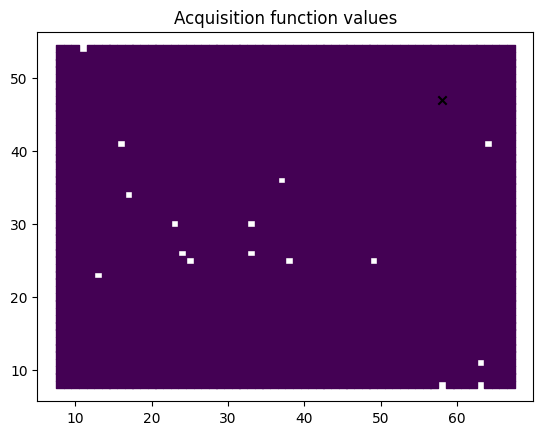

13/80


100%|██████████| 100/100 [00:01<00:00, 64.76it/s, init loss: 20140.4490, avg. loss [96-100]: 19062.6332]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3345
noise            0.0766


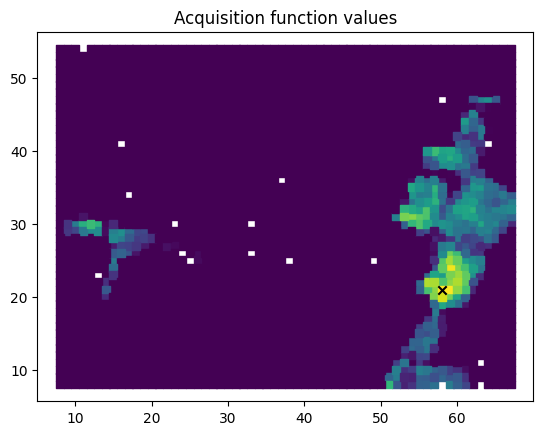

14/80


100%|██████████| 100/100 [00:01<00:00, 62.87it/s, init loss: 20141.7078, avg. loss [96-100]: 19062.7751]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32880000000000004
noise            0.0767


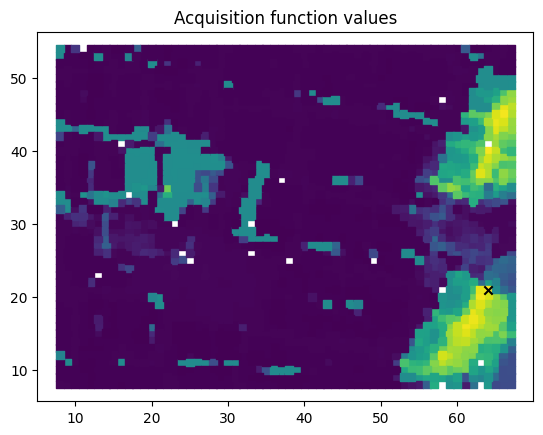

15/80


100%|██████████| 100/100 [00:01<00:00, 63.56it/s, init loss: 20143.0298, avg. loss [96-100]: 19062.7252]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33290000000000003
noise            0.0748


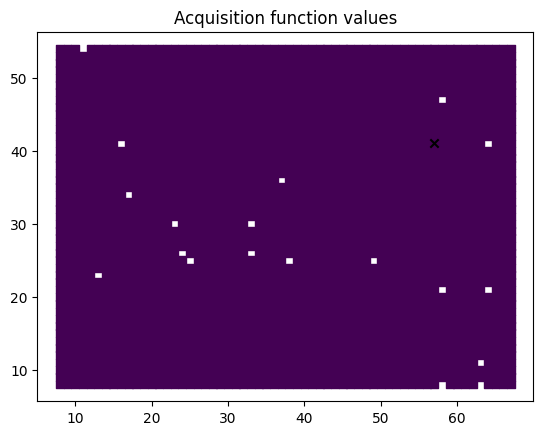

16/80


100%|██████████| 100/100 [00:01<00:00, 64.67it/s, init loss: 20144.2855, avg. loss [96-100]: 19062.8915]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3276
noise            0.0753


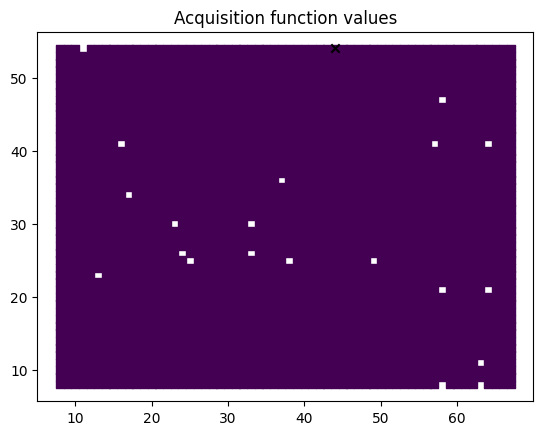

17/80


100%|██████████| 100/100 [00:01<00:00, 63.61it/s, init loss: 20145.5340, avg. loss [96-100]: 19081.3018]



Inferred GP kernel parameters
k_length         [1.432  1.7482]
k_scale          0.2343
noise            0.0386


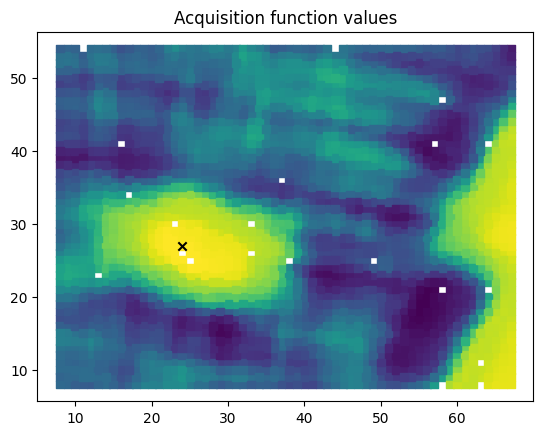

18/80


100%|██████████| 100/100 [00:01<00:00, 54.97it/s, init loss: 20146.8882, avg. loss [96-100]: 19063.2022]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3266
noise            0.0755


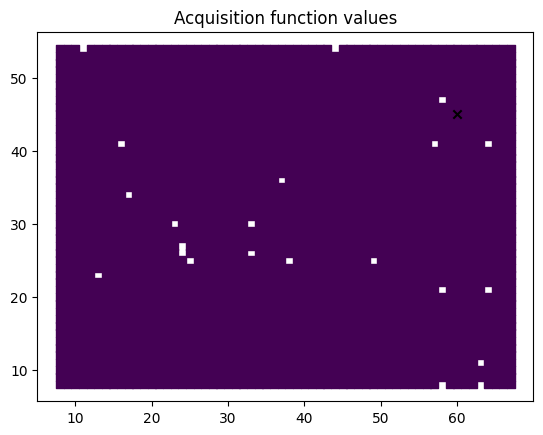

19/80


100%|██████████| 100/100 [00:01<00:00, 65.61it/s, init loss: 20148.1457, avg. loss [96-100]: 19063.3126]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3225
noise            0.0753


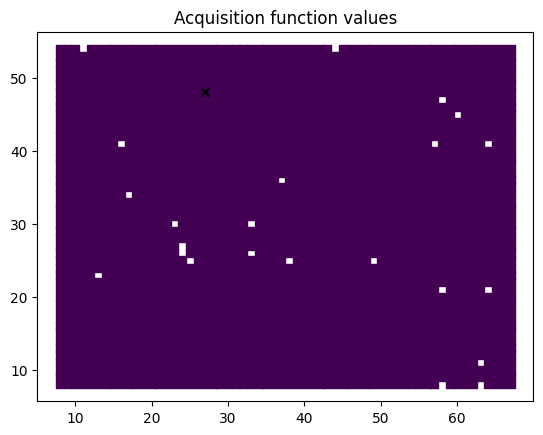

20/80


100%|██████████| 100/100 [00:01<00:00, 65.26it/s, init loss: 20149.3221, avg. loss [96-100]: 19085.0964]



Inferred GP kernel parameters
k_length         [1.7644 2.0925]
k_scale          0.2174
noise            0.038900000000000004


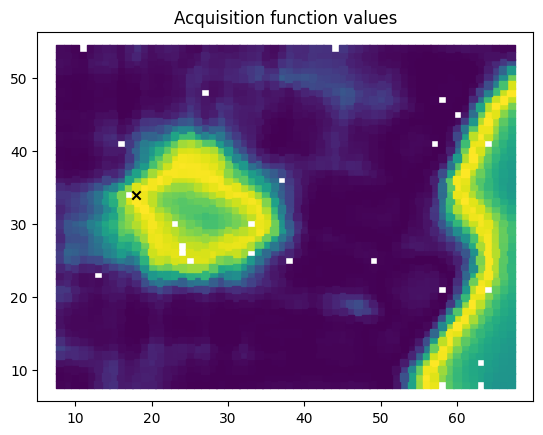

21/80


100%|██████████| 100/100 [00:01<00:00, 62.49it/s, init loss: 20150.6408, avg. loss [96-100]: 19083.0370]



Inferred GP kernel parameters
k_length         [1.9804 2.4835]
k_scale          0.2124
noise            0.0351


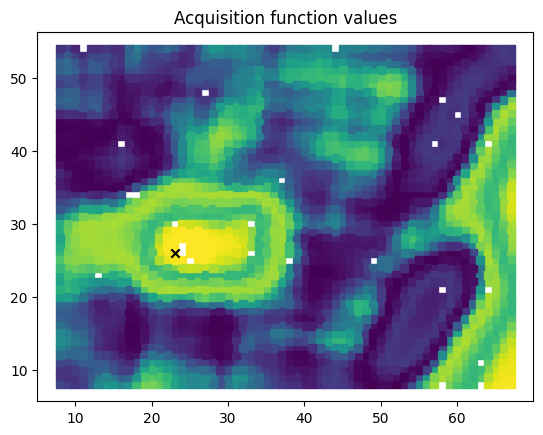

22/80


100%|██████████| 100/100 [00:01<00:00, 62.58it/s, init loss: 20152.0410, avg. loss [96-100]: 19075.4772]



Inferred GP kernel parameters
k_length         [2.2979 2.3439]
k_scale          0.22790000000000002
noise            0.0304


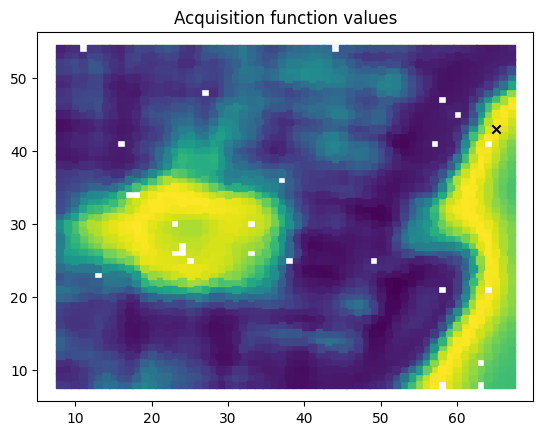

23/80


100%|██████████| 100/100 [00:01<00:00, 58.94it/s, init loss: 20153.3341, avg. loss [96-100]: 19087.2028]



Inferred GP kernel parameters
k_length         [2.3658 1.8691]
k_scale          0.2281
noise            0.027800000000000002


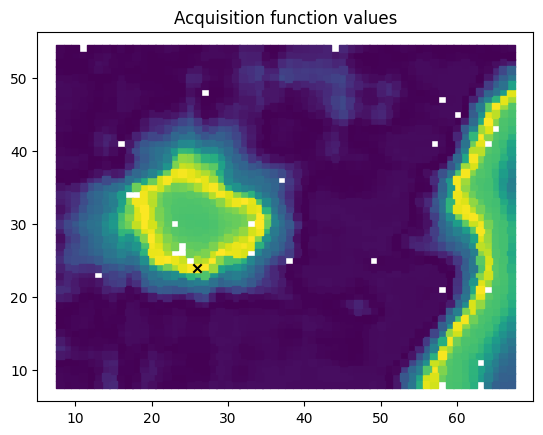

24/80


100%|██████████| 100/100 [00:01<00:00, 60.76it/s, init loss: 20154.7290, avg. loss [96-100]: 19064.3124]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3345
noise            0.07690000000000001


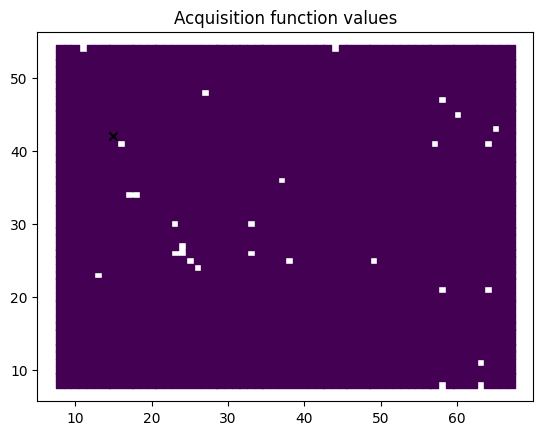

25/80


100%|██████████| 100/100 [00:02<00:00, 47.18it/s, init loss: 20155.9535, avg. loss [96-100]: 19064.6078]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3305
noise            0.0779


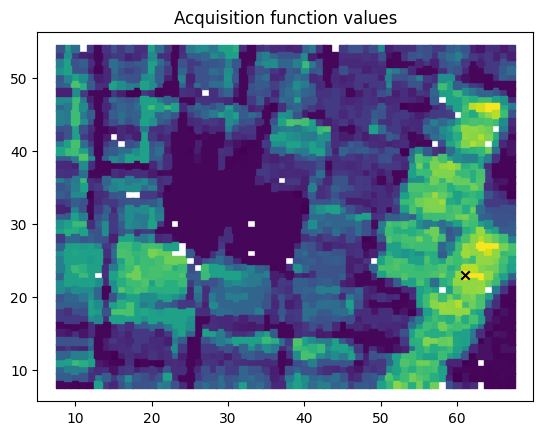

26/80


100%|██████████| 100/100 [00:01<00:00, 62.07it/s, init loss: 20157.2075, avg. loss [96-100]: 19113.8684]



Inferred GP kernel parameters
k_length         [2.9969 2.2692]
k_scale          0.1947
noise            0.0324


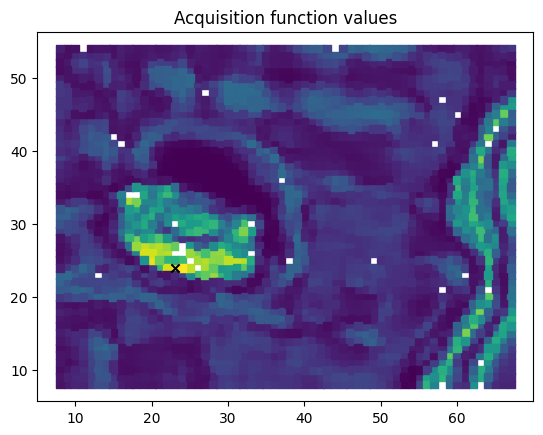

27/80


100%|██████████| 100/100 [00:01<00:00, 60.40it/s, init loss: 20158.5861, avg. loss [96-100]: 19098.9591]



Inferred GP kernel parameters
k_length         [3.1155 2.8758]
k_scale          0.2187
noise            0.028800000000000003


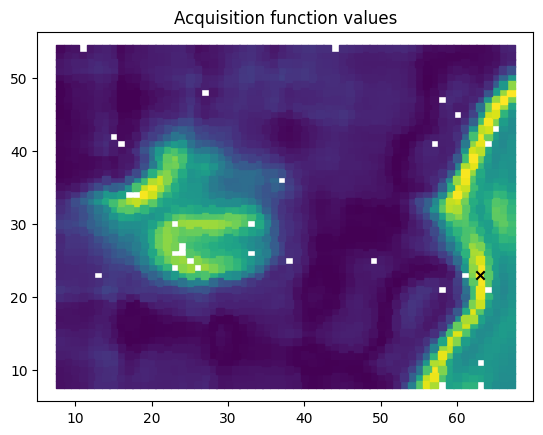

28/80


100%|██████████| 100/100 [00:01<00:00, 59.34it/s, init loss: 20159.8695, avg. loss [96-100]: 19085.4784]



Inferred GP kernel parameters
k_length         [3.2091 2.6672]
k_scale          0.2301
noise            0.030100000000000002


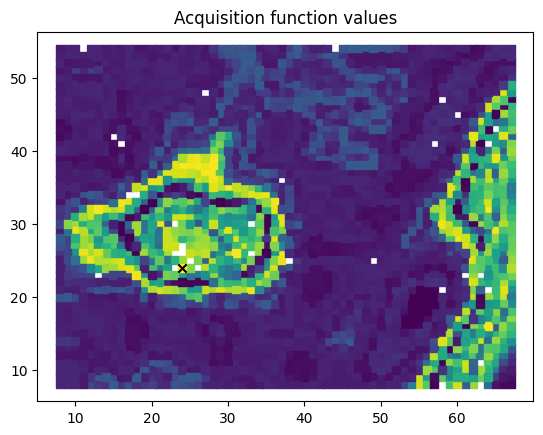

29/80


100%|██████████| 100/100 [00:01<00:00, 64.33it/s, init loss: 20161.1366, avg. loss [96-100]: 19108.3416]



Inferred GP kernel parameters
k_length         [3.2725 4.9914]
k_scale          0.22210000000000002
noise            0.0325


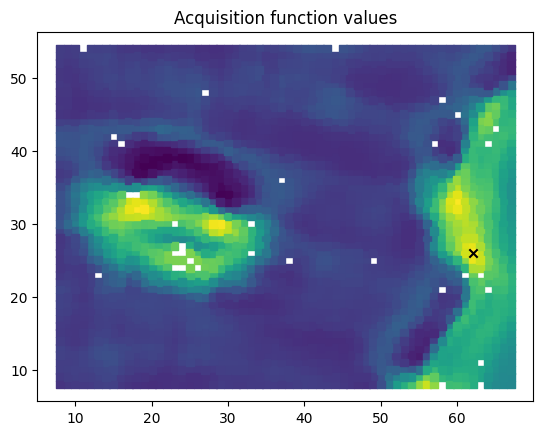

30/80


100%|██████████| 100/100 [00:01<00:00, 63.45it/s, init loss: 20162.3550, avg. loss [96-100]: 19113.0640]



Inferred GP kernel parameters
k_length         [3.9107 3.2961]
k_scale          0.184
noise            0.0291


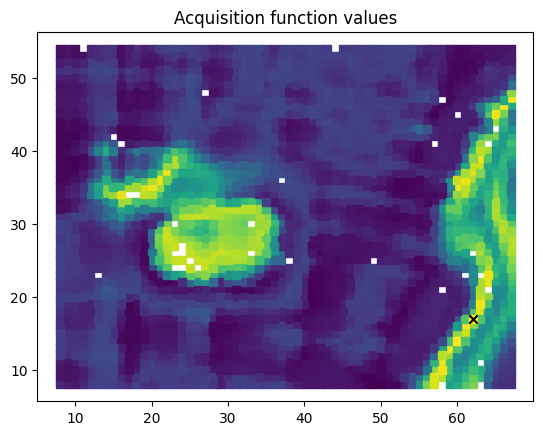

31/80


100%|██████████| 100/100 [00:02<00:00, 46.21it/s, init loss: 20163.6597, avg. loss [96-100]: 19063.9143]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3388
noise            0.07050000000000001


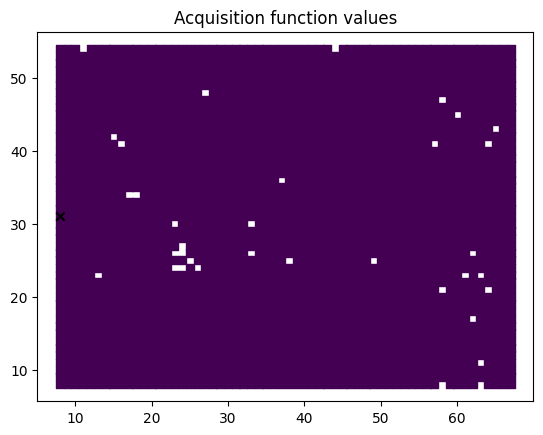

32/80


100%|██████████| 100/100 [00:01<00:00, 63.05it/s, init loss: 20164.9318, avg. loss [96-100]: 19112.2060]



Inferred GP kernel parameters
k_length         [3.1944 3.3581]
k_scale          0.2121
noise            0.0263


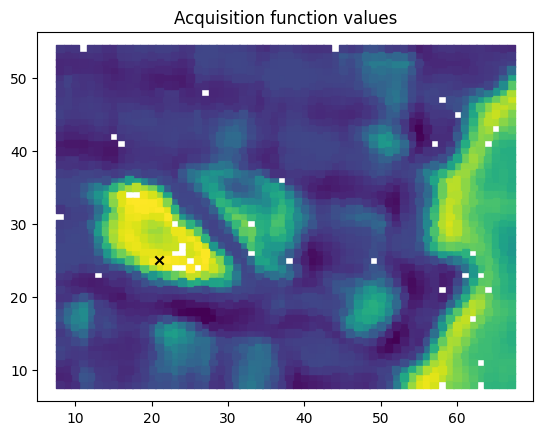

33/80


100%|██████████| 100/100 [00:01<00:00, 57.46it/s, init loss: 20166.2461, avg. loss [96-100]: 19064.3986]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3406
noise            0.0716


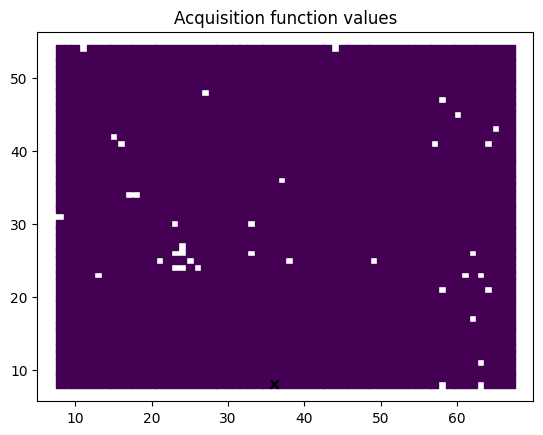

34/80


100%|██████████| 100/100 [00:01<00:00, 63.15it/s, init loss: 20167.4398, avg. loss [96-100]: 19126.4018]



Inferred GP kernel parameters
k_length         [3.6712 3.6943]
k_scale          0.21150000000000002
noise            0.0268


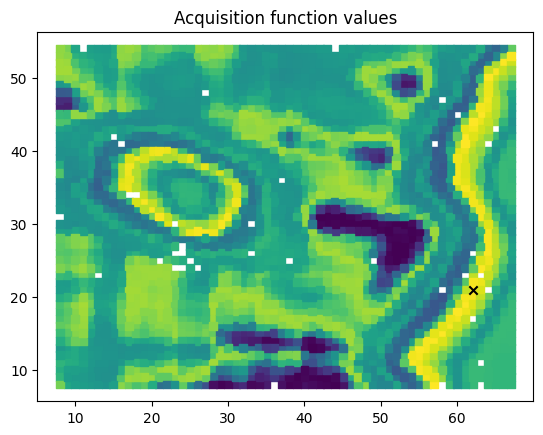

35/80


100%|██████████| 100/100 [00:01<00:00, 64.06it/s, init loss: 20168.8370, avg. loss [96-100]: 19075.1130]



Inferred GP kernel parameters
k_length         [3.5137 2.592 ]
k_scale          0.2278
noise            0.025900000000000003


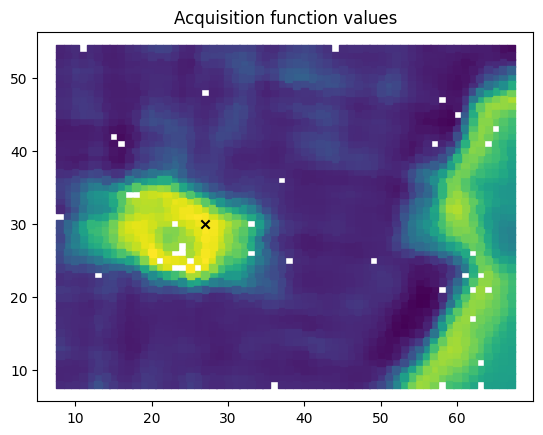

36/80


100%|██████████| 100/100 [00:01<00:00, 64.12it/s, init loss: 20170.0675, avg. loss [96-100]: 19064.8080]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3415
noise            0.07200000000000001


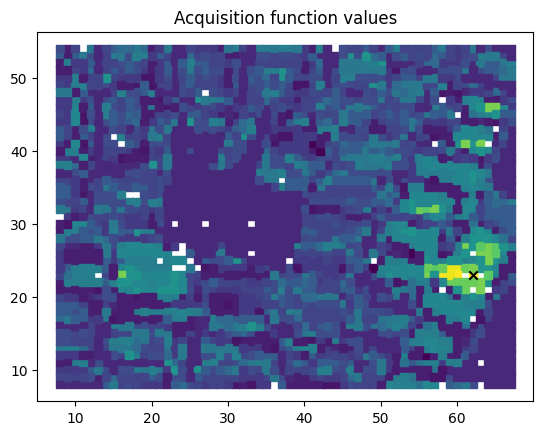

37/80


100%|██████████| 100/100 [00:01<00:00, 64.26it/s, init loss: 20171.2973, avg. loss [96-100]: 19067.8132]



Inferred GP kernel parameters
k_length         [4.8621 3.0412]
k_scale          0.1986
noise            0.022500000000000003


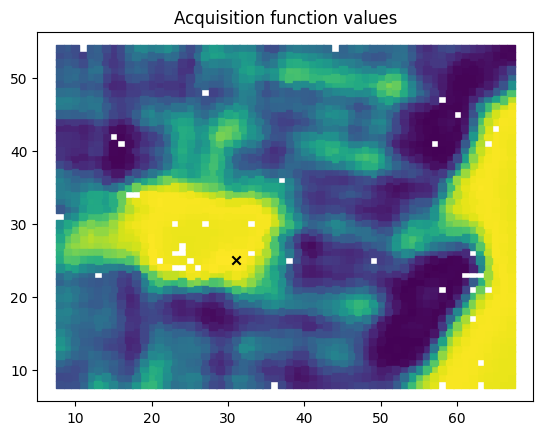

38/80


100%|██████████| 100/100 [00:01<00:00, 62.25it/s, init loss: 20172.6797, avg. loss [96-100]: 19116.2559]



Inferred GP kernel parameters
k_length         [4.1412 3.571 ]
k_scale          0.23340000000000002
noise            0.0263


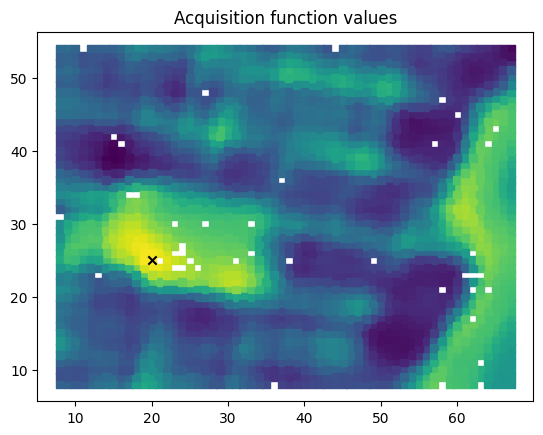

39/80


100%|██████████| 100/100 [00:01<00:00, 55.99it/s, init loss: 20174.0169, avg. loss [96-100]: 19084.6178]



Inferred GP kernel parameters
k_length         [3.6901 3.2962]
k_scale          0.21350000000000002
noise            0.0236


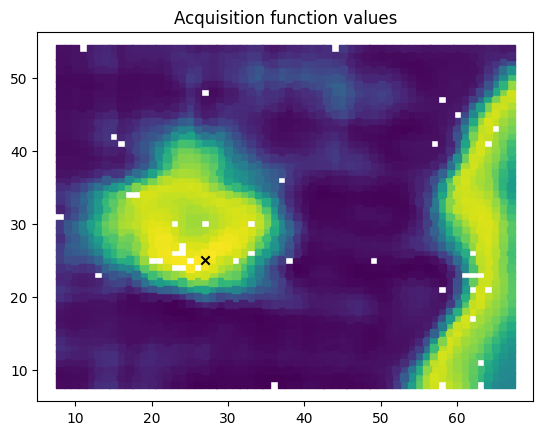

40/80


100%|██████████| 100/100 [00:01<00:00, 63.17it/s, init loss: 20175.4053, avg. loss [96-100]: 19064.7793]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3483
noise            0.0704


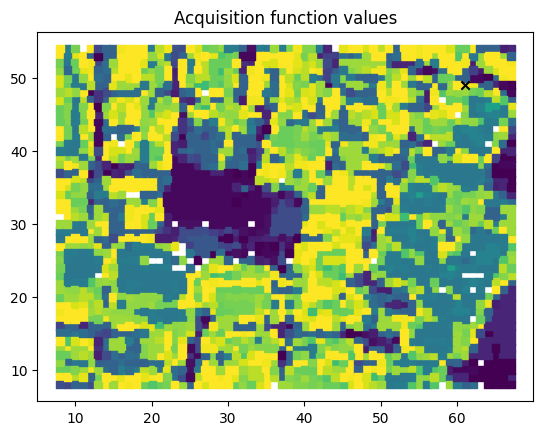

41/80


100%|██████████| 100/100 [00:01<00:00, 64.00it/s, init loss: 20176.6488, avg. loss [96-100]: 19124.0232]



Inferred GP kernel parameters
k_length         [6.0063 7.0085]
k_scale          0.1882
noise            0.027200000000000002


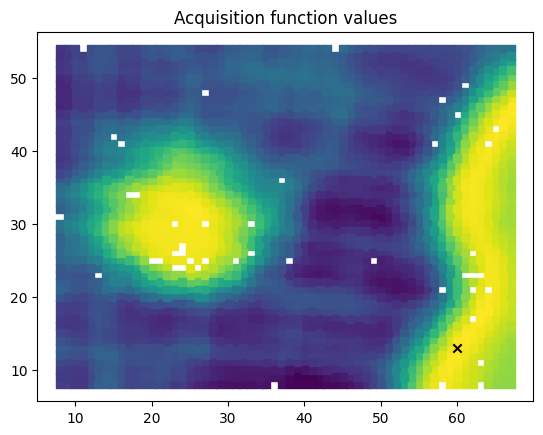

42/80


100%|██████████| 100/100 [00:01<00:00, 63.64it/s, init loss: 20177.9153, avg. loss [96-100]: 19100.7254]



Inferred GP kernel parameters
k_length         [4.3662 5.0054]
k_scale          0.21330000000000002
noise            0.0234


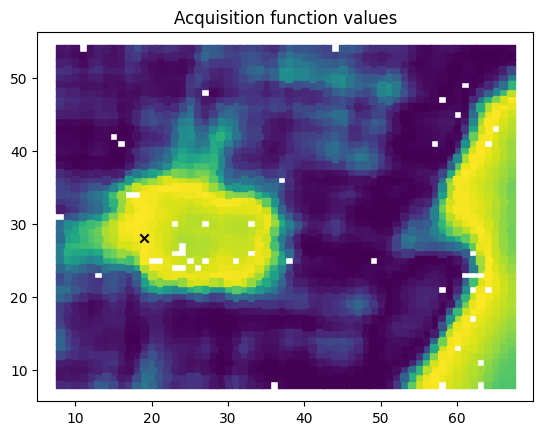

43/80


100%|██████████| 100/100 [00:01<00:00, 63.25it/s, init loss: 20179.1560, avg. loss [96-100]: 19160.2582]



Inferred GP kernel parameters
k_length         [9.1173 8.2912]
k_scale          0.1942
noise            0.025900000000000003


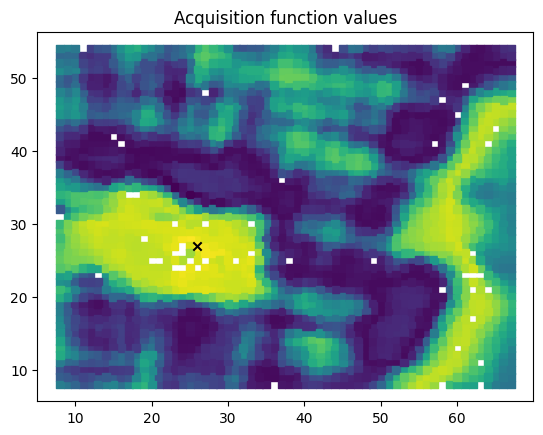

44/80


100%|██████████| 100/100 [00:01<00:00, 60.19it/s, init loss: 20180.4951, avg. loss [96-100]: 19133.6771]



Inferred GP kernel parameters
k_length         [4.231  3.4023]
k_scale          0.2054
noise            0.021


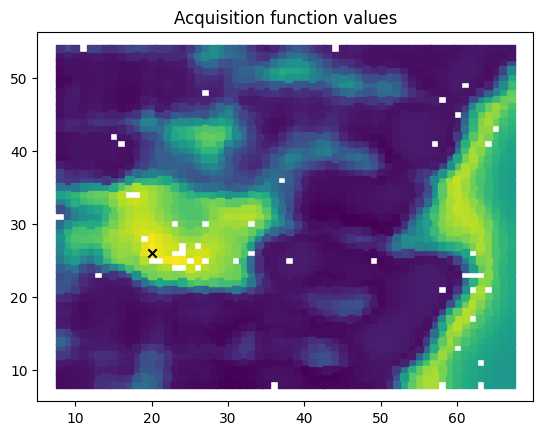

45/80


100%|██████████| 100/100 [00:02<00:00, 40.86it/s, init loss: 20181.7481, avg. loss [96-100]: 19115.8390]



Inferred GP kernel parameters
k_length         [4.6388 5.0981]
k_scale          0.202
noise            0.024200000000000003


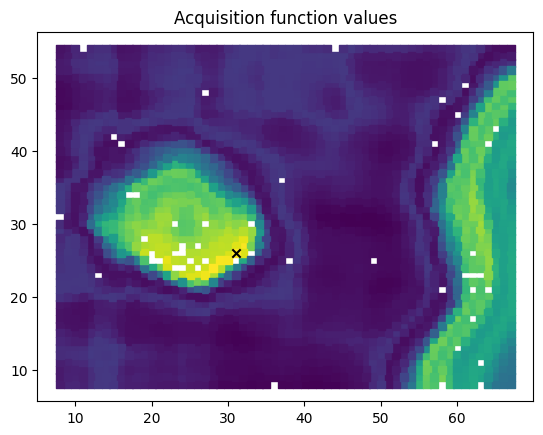

46/80


100%|██████████| 100/100 [00:01<00:00, 62.75it/s, init loss: 20183.0243, avg. loss [96-100]: 19061.2606]



Inferred GP kernel parameters
k_length         [4.5282 3.4899]
k_scale          0.21880000000000002
noise            0.021


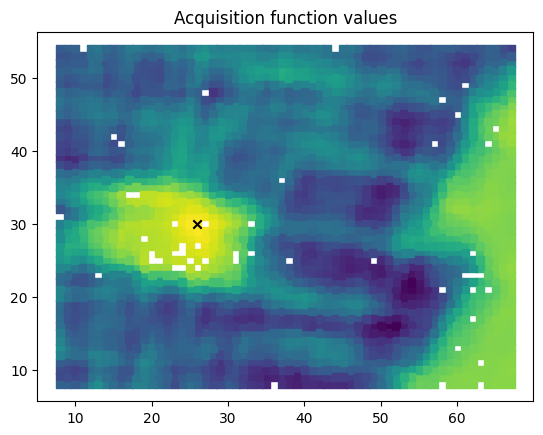

47/80


100%|██████████| 100/100 [00:01<00:00, 63.51it/s, init loss: 20184.3418, avg. loss [96-100]: 19107.7210]



Inferred GP kernel parameters
k_length         [3.7536 7.2192]
k_scale          0.1925
noise            0.023100000000000002


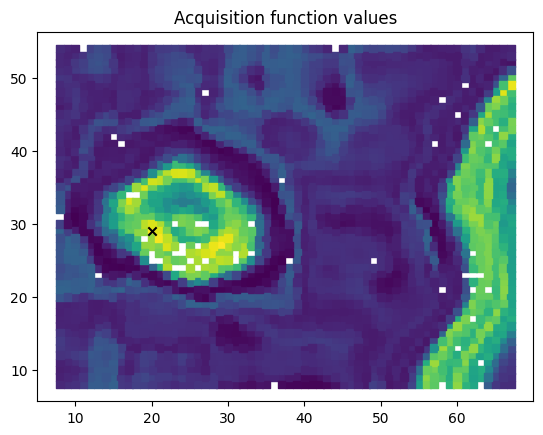

48/80


100%|██████████| 100/100 [00:01<00:00, 64.31it/s, init loss: 20185.6229, avg. loss [96-100]: 19111.8865]



Inferred GP kernel parameters
k_length         [6.0542 5.1792]
k_scale          0.2157
noise            0.026000000000000002


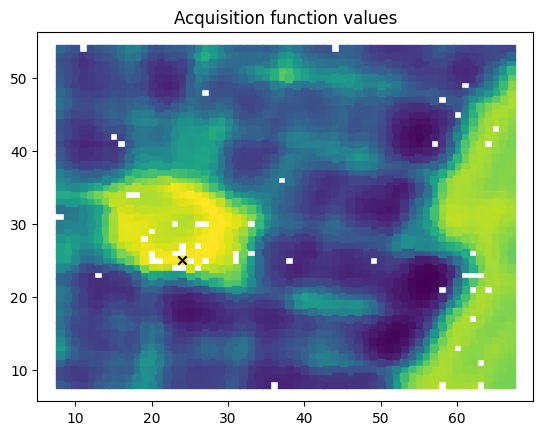

49/80


100%|██████████| 100/100 [00:01<00:00, 62.33it/s, init loss: 20186.9690, avg. loss [96-100]: 19083.3962]



Inferred GP kernel parameters
k_length         [4.9643 4.9305]
k_scale          0.21280000000000002
noise            0.0216


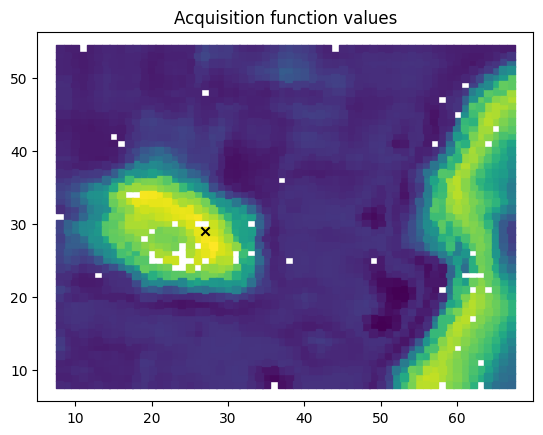

50/80


100%|██████████| 100/100 [00:01<00:00, 63.08it/s, init loss: 20188.2088, avg. loss [96-100]: 19096.3520]



Inferred GP kernel parameters
k_length         [6.4059 5.8619]
k_scale          0.1967
noise            0.020300000000000002


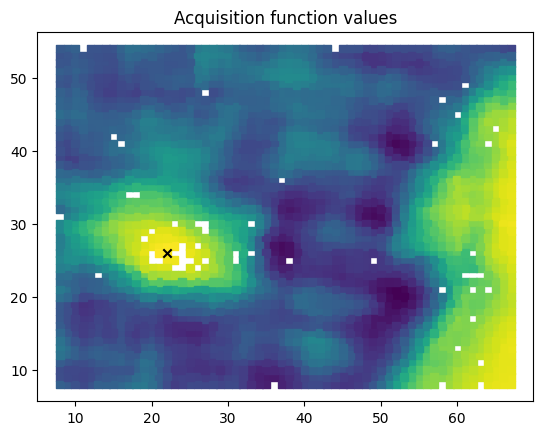

51/80


100%|██████████| 100/100 [00:01<00:00, 64.04it/s, init loss: 20189.4588, avg. loss [96-100]: 19049.4077]



Inferred GP kernel parameters
k_length         [2.7689 3.5512]
k_scale          0.2124
noise            0.017


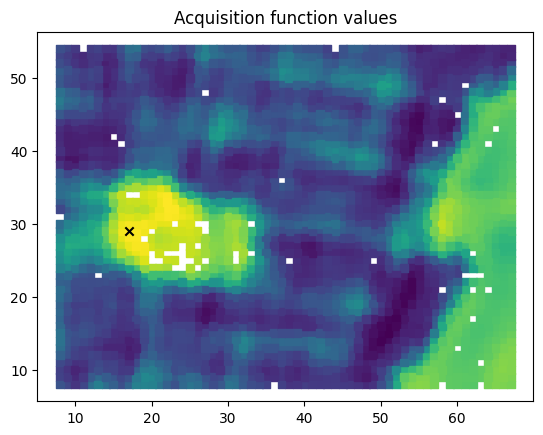

52/80


100%|██████████| 100/100 [00:01<00:00, 55.33it/s, init loss: 20190.7660, avg. loss [96-100]: 19059.5393]



Inferred GP kernel parameters
k_length         [7.1716 4.2826]
k_scale          0.21100000000000002
noise            0.0204


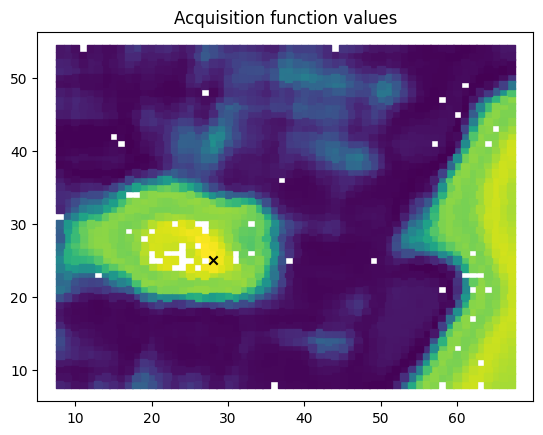

53/80


100%|██████████| 100/100 [00:01<00:00, 53.91it/s, init loss: 20192.1491, avg. loss [96-100]: 19090.2876]



Inferred GP kernel parameters
k_length         [8.7455 6.839 ]
k_scale          0.19920000000000002
noise            0.0222


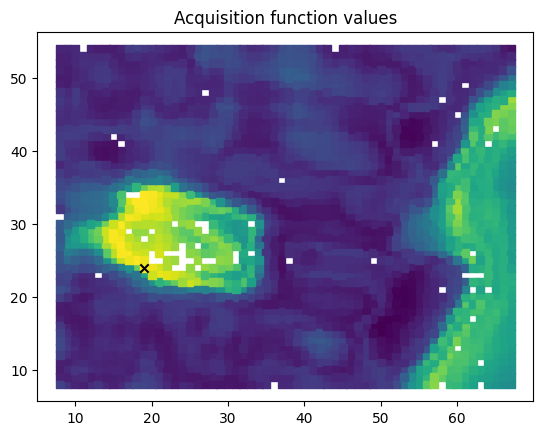

54/80


100%|██████████| 100/100 [00:01<00:00, 63.76it/s, init loss: 20193.3421, avg. loss [96-100]: 19116.4397]



Inferred GP kernel parameters
k_length         [5.4858 5.1597]
k_scale          0.20600000000000002
noise            0.0198


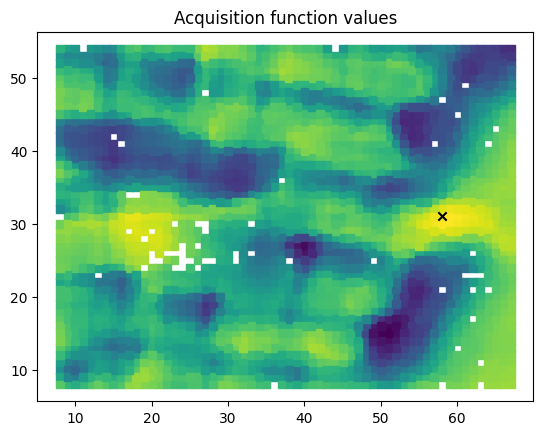

55/80


100%|██████████| 100/100 [00:01<00:00, 63.02it/s, init loss: 20194.6876, avg. loss [96-100]: 19101.3579]



Inferred GP kernel parameters
k_length         [5.6677 6.7636]
k_scale          0.1781
noise            0.0198


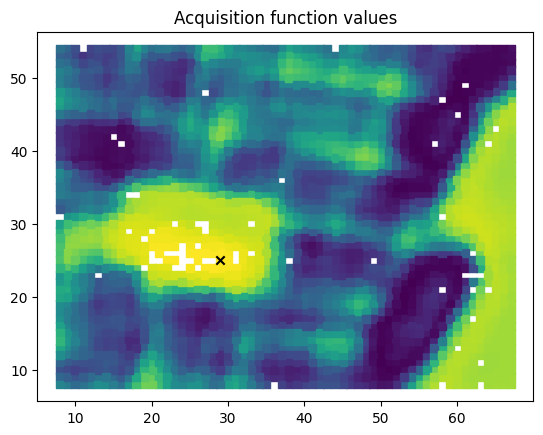

56/80


100%|██████████| 100/100 [00:01<00:00, 62.22it/s, init loss: 20195.9273, avg. loss [96-100]: 19117.3563]



Inferred GP kernel parameters
k_length         [6.7527 5.1486]
k_scale          0.2026
noise            0.0205


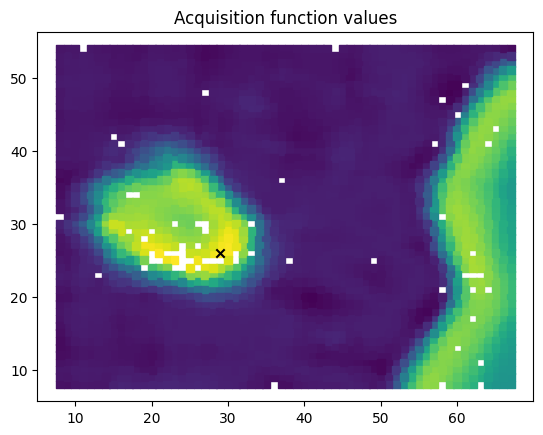

57/80


100%|██████████| 100/100 [00:01<00:00, 62.28it/s, init loss: 20197.1497, avg. loss [96-100]: 19068.2719]



Inferred GP kernel parameters
k_length         [5.7395 6.5945]
k_scale          0.1983
noise            0.019


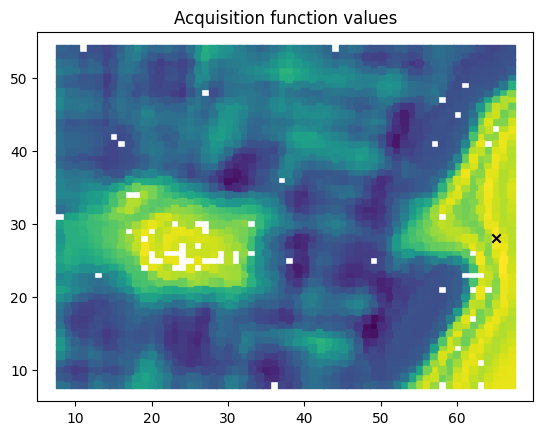

58/80


100%|██████████| 100/100 [00:01<00:00, 63.10it/s, init loss: 20198.4977, avg. loss [96-100]: 19059.2611]



Inferred GP kernel parameters
k_length         [6.8055 7.6188]
k_scale          0.18810000000000002
noise            0.0187


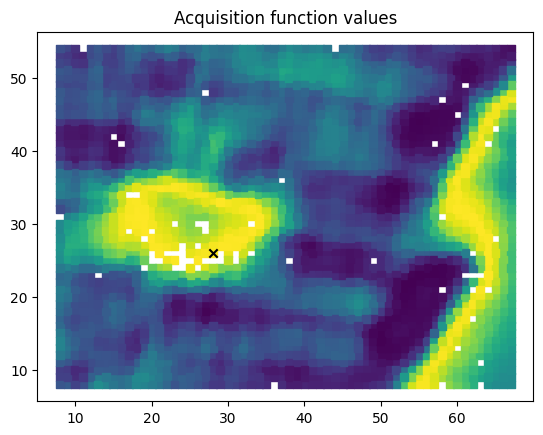

59/80


100%|██████████| 100/100 [00:01<00:00, 62.99it/s, init loss: 20199.8225, avg. loss [96-100]: 19049.3546]



Inferred GP kernel parameters
k_length         [3.6456 7.0922]
k_scale          0.22010000000000002
noise            0.0178


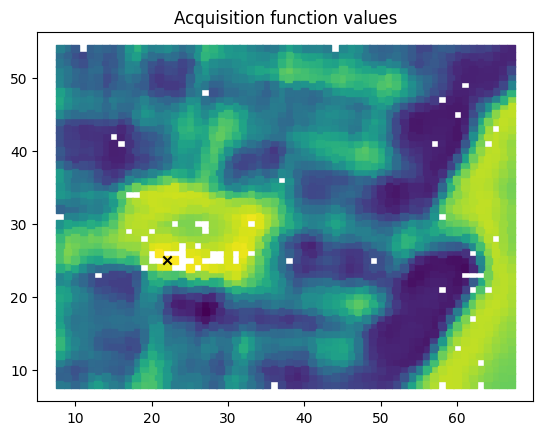

60/80


100%|██████████| 100/100 [00:01<00:00, 54.82it/s, init loss: 20201.0812, avg. loss [96-100]: 19042.0298]



Inferred GP kernel parameters
k_length         [3.9109 3.9526]
k_scale          0.2296
noise            0.0165


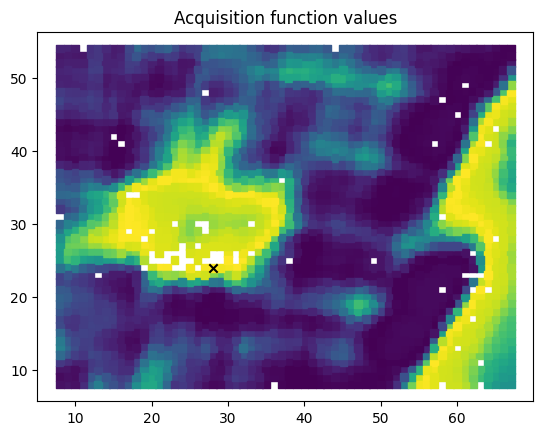

61/80


100%|██████████| 100/100 [00:01<00:00, 53.60it/s, init loss: 20202.2412, avg. loss [96-100]: 19085.6466]



Inferred GP kernel parameters
k_length         [7.9428 5.6404]
k_scale          0.18560000000000001
noise            0.0181


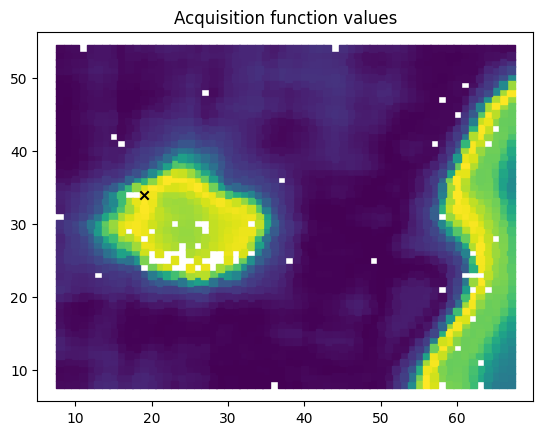

62/80


100%|██████████| 100/100 [00:01<00:00, 59.03it/s, init loss: 20203.4152, avg. loss [96-100]: 19045.8440]



Inferred GP kernel parameters
k_length         [4.8501 4.7744]
k_scale          0.21000000000000002
noise            0.016300000000000002


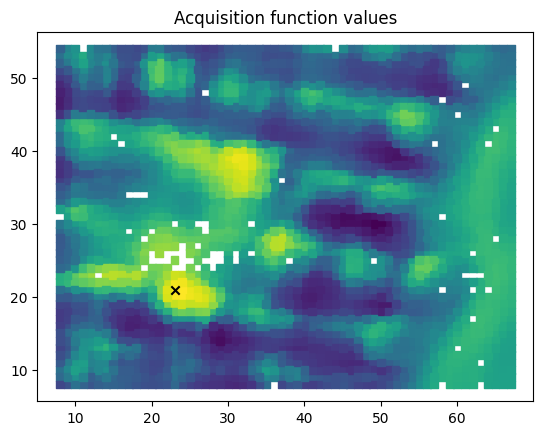

63/80


100%|██████████| 100/100 [00:01<00:00, 62.23it/s, init loss: 20204.6018, avg. loss [96-100]: 19192.6300]



Inferred GP kernel parameters
k_length         [10.9063  8.2139]
k_scale          0.19940000000000002
noise            0.0204


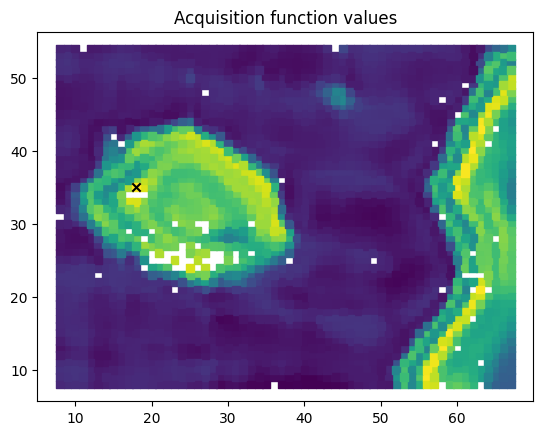

64/80


100%|██████████| 100/100 [00:01<00:00, 62.94it/s, init loss: 20205.8307, avg. loss [96-100]: 19151.5901]



Inferred GP kernel parameters
k_length         [ 9.5168 11.5312]
k_scale          0.185
noise            0.0187


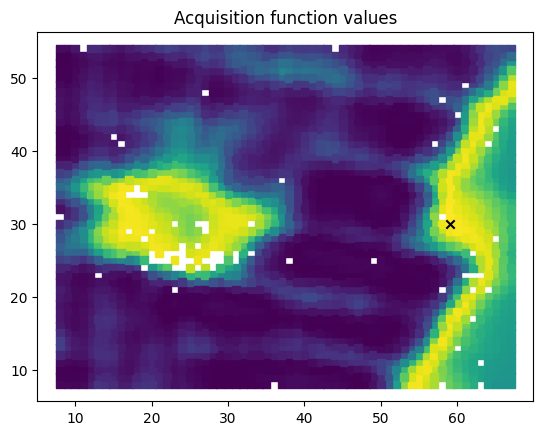

65/80


100%|██████████| 100/100 [00:01<00:00, 62.70it/s, init loss: 20207.1904, avg. loss [96-100]: 19060.2296]



Inferred GP kernel parameters
k_length         [6.5741 4.2725]
k_scale          0.20040000000000002
noise            0.016900000000000002


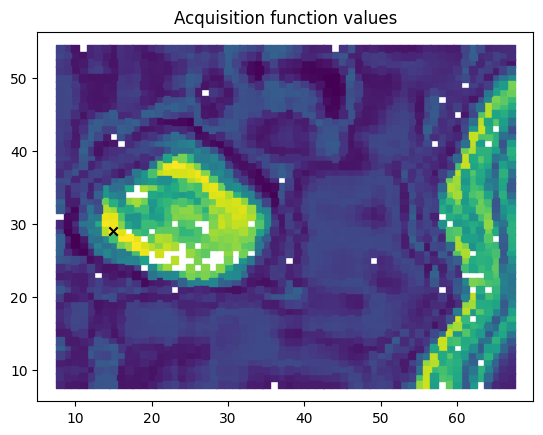

66/80


100%|██████████| 100/100 [00:01<00:00, 61.44it/s, init loss: 20208.3307, avg. loss [96-100]: 19063.7900]



Inferred GP kernel parameters
k_length         [4.2779 6.3692]
k_scale          0.1895
noise            0.0154


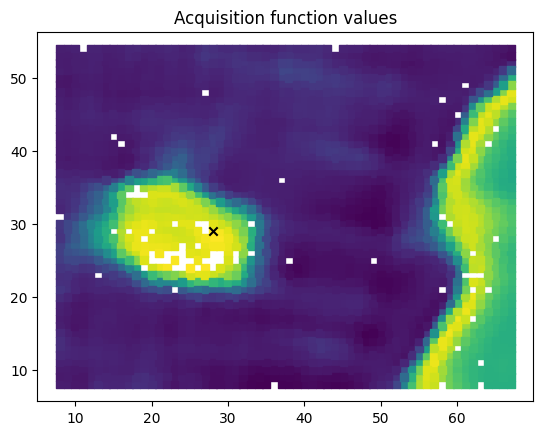

67/80


100%|██████████| 100/100 [00:01<00:00, 62.31it/s, init loss: 20209.5420, avg. loss [96-100]: 19058.9228]



Inferred GP kernel parameters
k_length         [5.7447 7.3371]
k_scale          0.18460000000000001
noise            0.0194


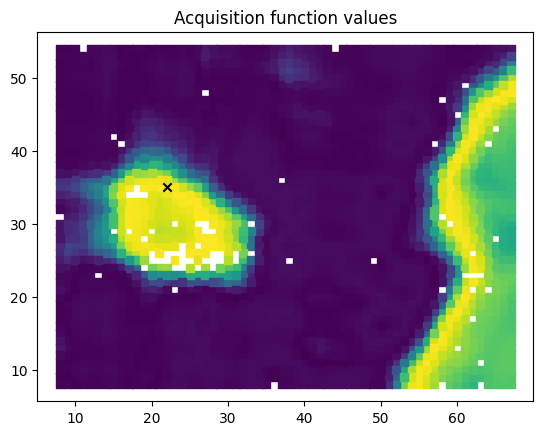

68/80


100%|██████████| 100/100 [00:01<00:00, 62.31it/s, init loss: 20210.8554, avg. loss [96-100]: 19060.2147]



Inferred GP kernel parameters
k_length         [5.7731 7.1317]
k_scale          0.1859
noise            0.0177


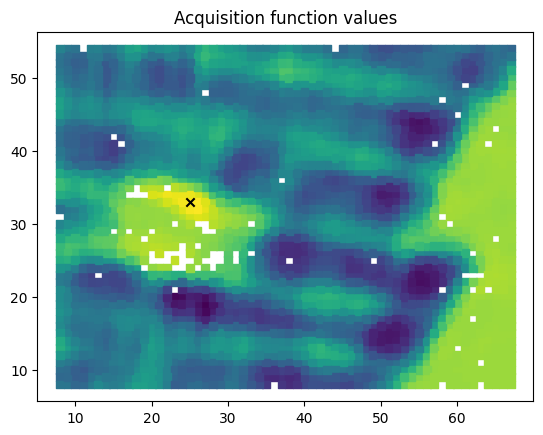

69/80


100%|██████████| 100/100 [00:01<00:00, 61.30it/s, init loss: 20212.0167, avg. loss [96-100]: 19052.7740]



Inferred GP kernel parameters
k_length         [4.5785 4.8268]
k_scale          0.1995
noise            0.0161


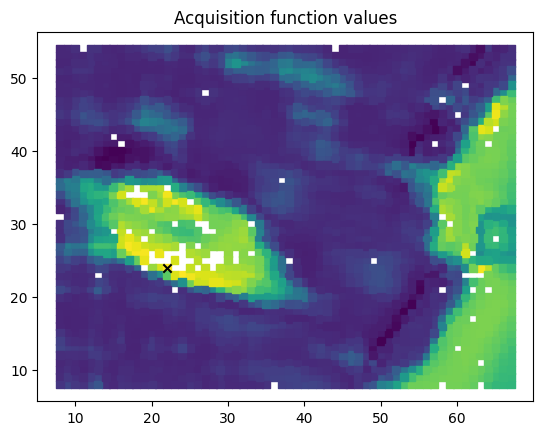

70/80


100%|██████████| 100/100 [00:01<00:00, 54.23it/s, init loss: 20213.2680, avg. loss [96-100]: 19067.9014]



Inferred GP kernel parameters
k_length         [7.4258 8.8872]
k_scale          0.16690000000000002
noise            0.0187


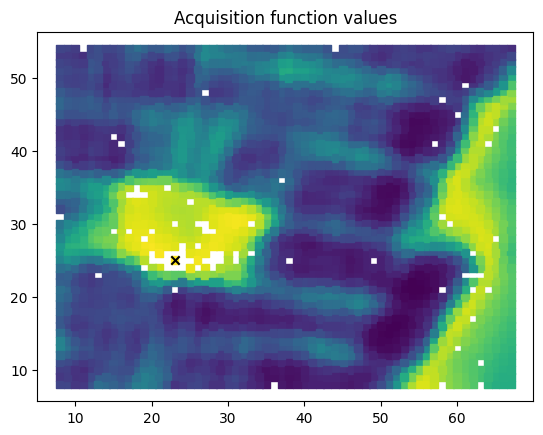

71/80


100%|██████████| 100/100 [00:01<00:00, 54.02it/s, init loss: 20214.4443, avg. loss [96-100]: 19180.9989]



Inferred GP kernel parameters
k_length         [8.1071 7.5161]
k_scale          0.19160000000000002
noise            0.0187


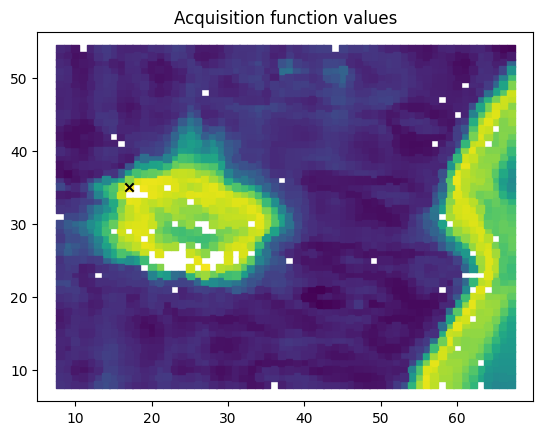

72/80


100%|██████████| 100/100 [00:01<00:00, 60.51it/s, init loss: 20215.7387, avg. loss [96-100]: 19089.4541]



Inferred GP kernel parameters
k_length         [9.0699 7.2714]
k_scale          0.1879
noise            0.0182


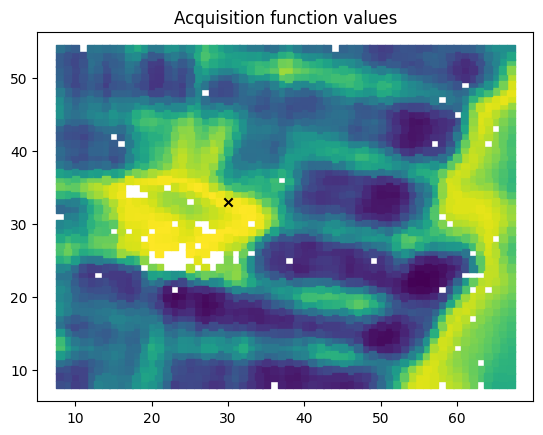

73/80


100%|██████████| 100/100 [00:01<00:00, 62.86it/s, init loss: 20216.9753, avg. loss [96-100]: 19185.5979]



Inferred GP kernel parameters
k_length         [ 9.6738 10.1321]
k_scale          0.1789
noise            0.020200000000000003


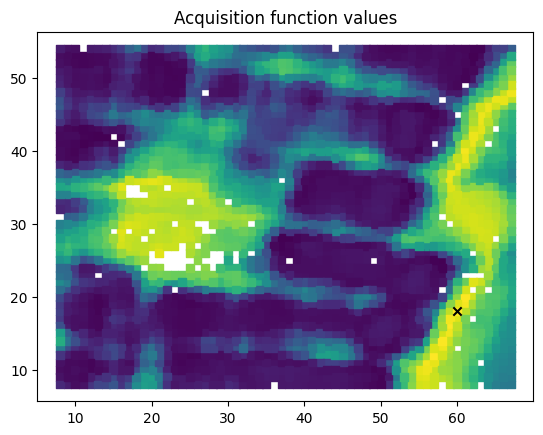

74/80


100%|██████████| 100/100 [00:01<00:00, 60.70it/s, init loss: 20218.3765, avg. loss [96-100]: 19116.5072]



Inferred GP kernel parameters
k_length         [6.1936 6.7284]
k_scale          0.1956
noise            0.0179


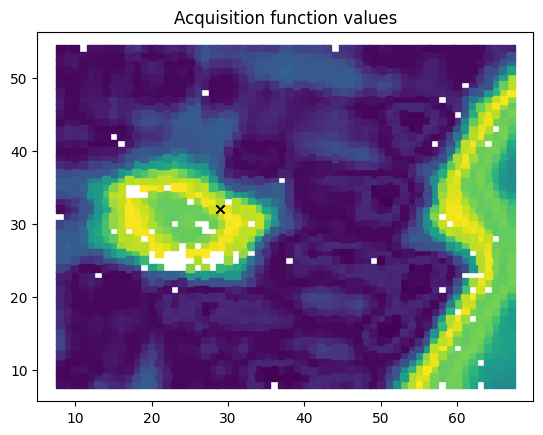

75/80


100%|██████████| 100/100 [00:01<00:00, 62.08it/s, init loss: 20219.7686, avg. loss [96-100]: 19087.1057]



Inferred GP kernel parameters
k_length         [8.9844 9.1482]
k_scale          0.17350000000000002
noise            0.0189


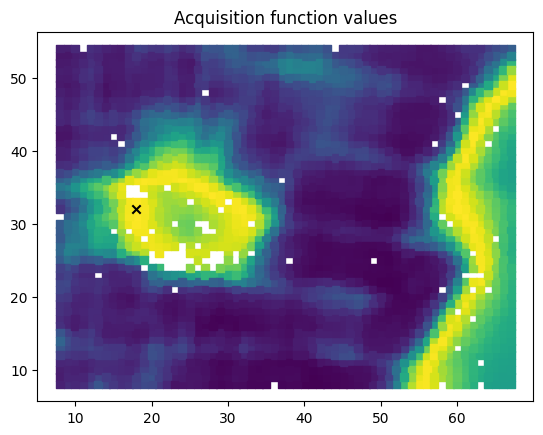

76/80


100%|██████████| 100/100 [00:01<00:00, 62.69it/s, init loss: 20221.1681, avg. loss [96-100]: 19102.4710]



Inferred GP kernel parameters
k_length         [6.3497 7.7132]
k_scale          0.18380000000000002
noise            0.019


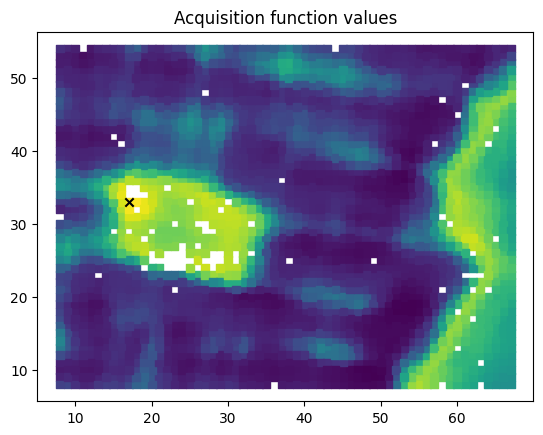

77/80


100%|██████████| 100/100 [00:01<00:00, 61.84it/s, init loss: 20222.5482, avg. loss [96-100]: 19053.9081]



Inferred GP kernel parameters
k_length         [6.5912 7.3554]
k_scale          0.18660000000000002
noise            0.0159


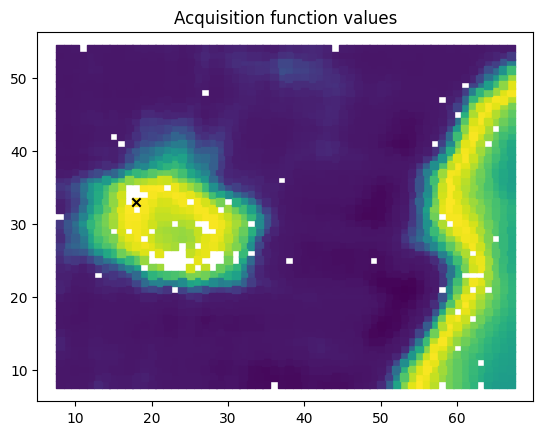

78/80


100%|██████████| 100/100 [00:01<00:00, 62.69it/s, init loss: 20223.8236, avg. loss [96-100]: 19089.6937]



Inferred GP kernel parameters
k_length         [12.0543 14.8821]
k_scale          0.17800000000000002
noise            0.0179


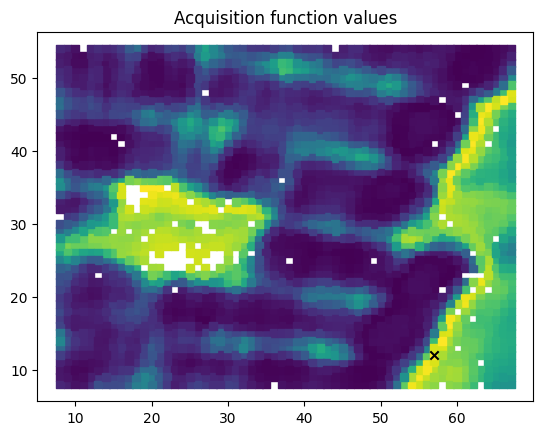

79/80


100%|██████████| 100/100 [00:01<00:00, 60.37it/s, init loss: 20225.2011, avg. loss [96-100]: 19036.5517]



Inferred GP kernel parameters
k_length         [5.8327 8.2681]
k_scale          0.1897
noise            0.0167


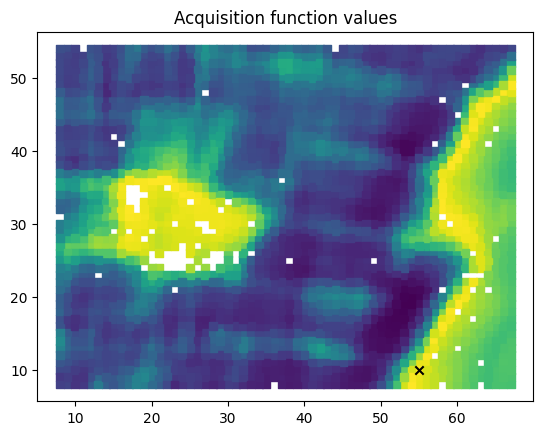

80/80


100%|██████████| 100/100 [00:02<00:00, 37.43it/s, init loss: 20226.4408, avg. loss [96-100]: 19056.8151]



Inferred GP kernel parameters
k_length         [7.1931 6.501 ]
k_scale          0.18730000000000002
noise            0.0159


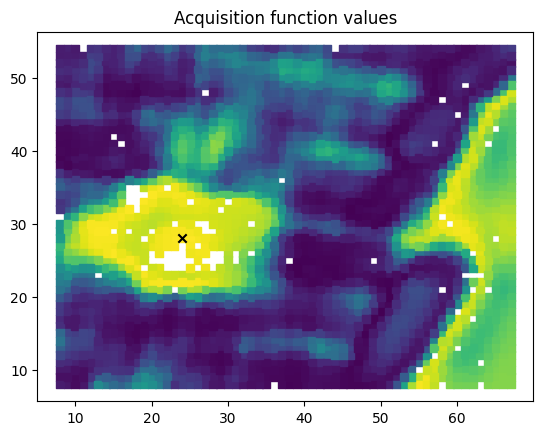

In [20]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=32, c=obj, marker='s')
    next_point = indices[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_measured.shape[-1]

exploration_steps = 80

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(  # you may decrease step size and increase number of steps (e.g. to 0.005 and 1000) for more stable performance
        key1, X_measured, y_measured, num_steps=100, step_size=0.05)
    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_unmeasured, beta=0.25, maximize=True)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    # Do "measurement"
    measured_point = y_unmeasured[next_point_idx]
    # Plot current result
    plot_result(indices_unmeasured, obj)
    # Update the arrays of measured/unmeasured points
    X_measured = np.append(X_measured, X_unmeasured[next_point_idx][None], 0)
    X_unmeasured = np.delete(X_unmeasured, next_point_idx, 0)
    y_measured = np.append(y_measured, measured_point)
    y_unmeasured = np.delete(y_unmeasured, next_point_idx)
    indices_measured = np.append(indices_measured, indices_unmeasured[next_point_idx][None], 0)
    indices_unmeasured = np.delete(indices_unmeasured, next_point_idx, 0)

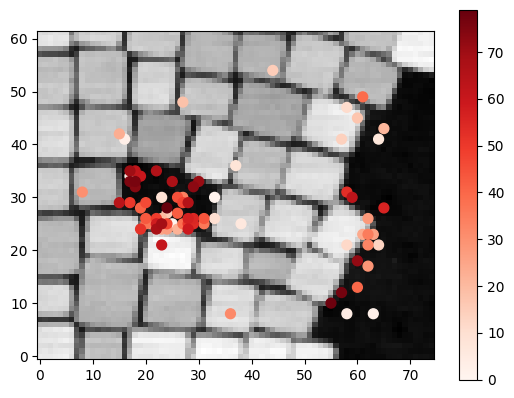

In [21]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_measured[seed_points:, 1], indices_measured[seed_points:, 0],
            c=np.arange(len(indices_measured[seed_points:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

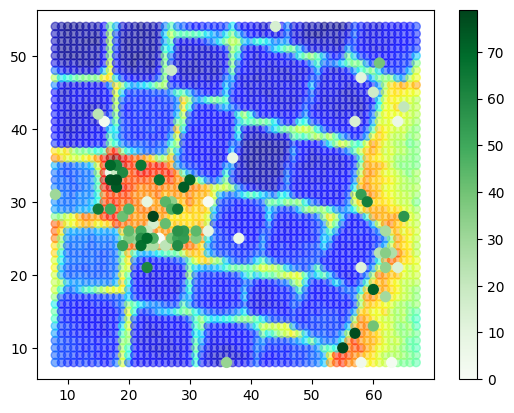

In [22]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_measured[seed_points:, 1], indices_measured[seed_points:, 0],
            c=np.arange(len(indices_measured[seed_points:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of interest is maximized.